# Компьютерное зрение: задача сегментации

**Автор**: Винник Екатерина Петровна, 22.М04

## Задача

Обучаем Сегментацию:
- https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.


- [+] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [+] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [+] Попробовать улучшить качество изменяя архитектуру.

## Подготовка датасета

Загрузим датасет, который был предварительно загружен на личный Google диск.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
from glob import glob
import random

images = glob("./gdrive/MyDrive/dataset/images/*")
masks = glob("./gdrive/MyDrive/dataset/masks/*")
print("Number of images:", len(images), " and masks:", len(masks))

Number of images: 2000  and masks: 2000


Реализуем класс для датасета с функцией доступа по индексу.

In [9]:
from torch.utils.data import Dataset
import numpy as np
import torch
from torchvision import io
import cv2
import torchvision.transforms as T

class MyDataset():
    def __init__(self, images, masks, transform=lambda t: t):
        self.images = images
        self.masks = masks
        self.transform = transform
        print("len of images = ", len(images))
        assert len(self.images) == len(self.masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        image = io.read_image(str(self.images[idx]))
        resize_f = T.Resize((256, 256))
        image = resize_f(image)
        image = self.transform(image / 255)

        mask = io.read_image(str(self.masks[idx]))
        mask = resize_f(mask)
        mask = self.transform(mask / 255)
        return image, mask

## Разбиение данных на тренировочную и тестовую выборки

In [10]:
def split_dataset(images_list, masks_list, train_ratio):
    paired = list(zip(images_list, masks_list))
    random.shuffle(paired)
    (images_list, masks_list) = zip(*paired)

    train_dataset = MyDataset(
    images=images_list[:int(len(images_list) * train_ratio)],
    masks=masks_list[:int(len(masks_list) * train_ratio)],
    )
    test_dataset = MyDataset(
        images=images_list[int(len(images_list) * train_ratio):],
        masks=masks_list[int(len(masks_list) * train_ratio):],
    )
    return train_dataset, test_dataset

train_ratio = 0.1
x_train, x_test = split_dataset(images, masks, train_ratio)

len of images =  200
len of images =  1800


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


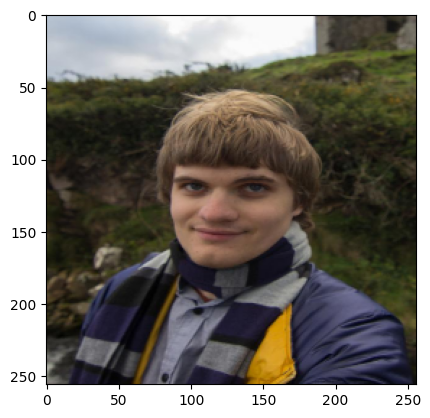

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional

image3, mask3 = x_train[42]
plt.imshow(functional.to_pil_image(image3))

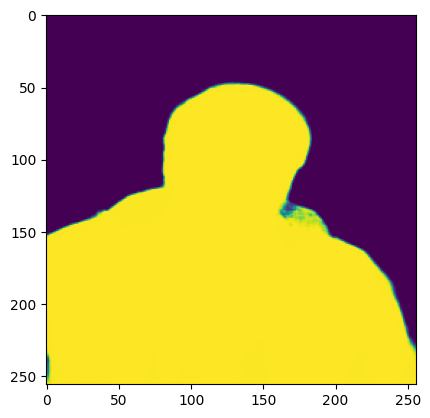

In [ ]:
from torchvision.transforms import functional
plt.imshow(functional.to_pil_image(mask3))

## Реализация U-Net

Реализуем UNet по аналогии с реализацией с пары.

In [11]:
device="cuda"

In [12]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNet, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)                

## Jaccard Index

In [13]:
!pip install torchmetrics
import torchmetrics
loss_fn = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.JaccardIndex(task="binary")


def calculate_jaccard_index(pred: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    return jaccard(pred.cpu(), y.cpu() > jaccard.threshold)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 21.4 MB/s eta 0:00:00


## Переобучение на одном батче

Фиксируем сиды

In [14]:
def reset_random_seeds():
    torch.manual_seed(42)
    random.seed(42)

In [15]:
reset_random_seeds()

In [16]:
import pandas as pd
from tqdm.auto import tqdm, trange

loss_fn = nn.BCEWithLogitsLoss()
net = UNet(3, 16, 1).to("cuda")
optimizer = torch.optim.Adam(net.parameters())

def train_epoch(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        loader: torch.utils.data.DataLoader,
        show_progress: bool = True,
):
    model.train()

    loss_sum = 0
    metric_sum = 0

    for X, y in tqdm(loader, desc="Training batch", disable=(not show_progress)):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        metric = calculate_jaccard_index(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

    return loss_sum / len(loader), metric_sum / len(loader)


def test(
        model: nn.Module,
        loader: torch.utils.data.DataLoader,
        show_progress: bool = True,
) -> tuple[float, float]:
    model.eval()

    loss_sum = 0
    metric_sum = 0
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Test batch", disable=(not show_progress)):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss_sum += loss_fn(pred, y).item()
            metric_sum += calculate_jaccard_index(pred, y).item()

    return loss_sum / len(loader), metric_sum / len(loader)


def train(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        train_loader: torch.utils.data.DataLoader,
        test_loader: torch.utils.data.DataLoader,
        epochs: int,
        show_detailed_progress: bool = True,
) -> pd.DataFrame:
    stats = []
    for epoch_i in trange(epochs, desc="Epoch"):
        loss_train, metric_train = train_epoch(
            model, optimizer, train_loader, show_detailed_progress
        )
        loss_test, metric_test = test(model, test_loader, show_detailed_progress)
        stats += [
            (epoch_i, "Loss", "Train", loss_train),
            (epoch_i, "Jaccard", "Train", metric_train),
            (epoch_i, "Loss", "Test", loss_test),
            (epoch_i, "Jaccard", "Test", metric_test),
        ]

    return stats

In [59]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(x_train, range(batch_size)),
    batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(x_test, range(batch_size)),
    batch_size=batch_size,
)

In [ ]:
stats = train(net, optimizer, train_loader, test_loader, 50)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
title = ["Epoch", "Statistic", "Dataset", "Value"]
df = pd.DataFrame(stats,columns=title)

## Кривые loss и jaccard index при переобучении на одном батче

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt

def show_loss_and_jaccard_index(stats, title):
    fig, (ax_loss, ax_jaccard) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))
    sns.lineplot(stats[stats["Statistic"] == "Loss"], x="Epoch", y="Value", hue="Dataset", ax=ax_loss,)
    ax_loss.set_title("Loss")
    sns.lineplot(stats[stats["Statistic"] == "Jaccard"], x="Epoch", y="Value", hue="Dataset", ax=ax_jaccard,)
    ax_jaccard.set_title("Jaccard index")
    fig.suptitle(title)
    fig.tight_layout()

In [ ]:
print(stats)

[(0, 'Loss', 'Train', 0.7067726850509644), (0, 'Jaccard', 'Train', 0.2787952125072479), (0, 'Loss', 'Test', 0.6938840746879578), (0, 'Jaccard', 'Test', 0.0), (1, 'Loss', 'Train', 0.6348835229873657), (1, 'Jaccard', 'Train', 0.4103041887283325), (1, 'Loss', 'Test', 0.6942828297615051), (1, 'Jaccard', 'Test', 0.0), (2, 'Loss', 'Train', 0.5935248136520386), (2, 'Jaccard', 'Train', 0.5059027671813965), (2, 'Loss', 'Test', 0.6948736310005188), (2, 'Jaccard', 'Test', 0.0), (3, 'Loss', 'Train', 0.568488359451294), (3, 'Jaccard', 'Train', 0.5823067426681519), (3, 'Loss', 'Test', 0.6956117153167725), (3, 'Jaccard', 'Test', 0.0), (4, 'Loss', 'Train', 0.5436944961547852), (4, 'Jaccard', 'Train', 0.6229034662246704), (4, 'Loss', 'Test', 0.6965320110321045), (4, 'Jaccard', 'Test', 0.0), (5, 'Loss', 'Train', 0.5268236398696899), (5, 'Jaccard', 'Train', 0.6558791399002075), (5, 'Loss', 'Test', 0.6977484226226807), (5, 'Jaccard', 'Test', 0.0), (6, 'Loss', 'Train', 0.5015693306922913), (6, 'Jaccard', '

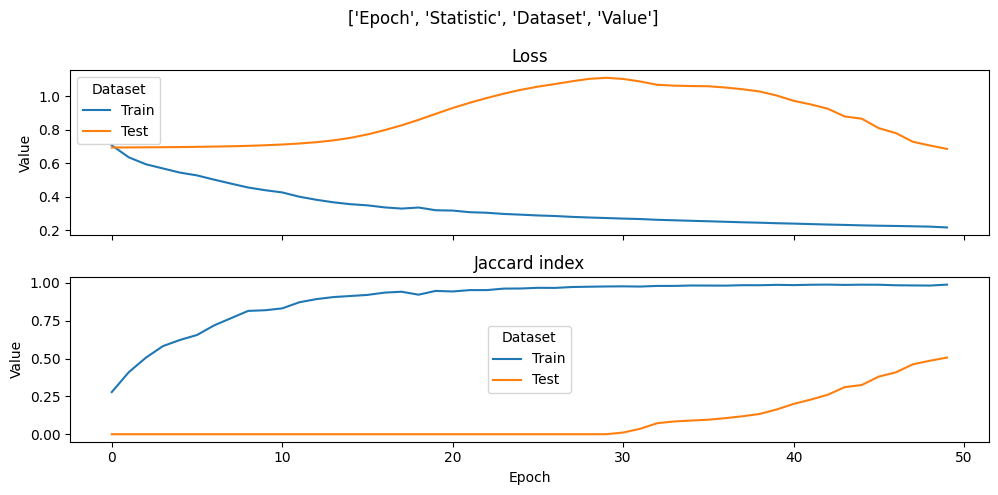

In [ ]:
show_loss_and_jaccard_index(df, title)

Графики Loss и Jaccard index демонстрируют, что хотя при переобучении на одном батче функция Jaccard index стремится к 1, значения функции Jaccard index на тестовой выборке довольно низкие. То есть, на элементах тестовой выборки видно, что задача сегментации решается плохо. Рассмотрим для примера изображение тестовой выборки и результат решения задачи сегментации для него.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


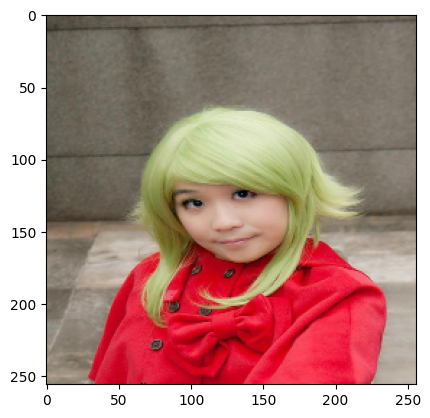

In [ ]:
net.eval()

image, _ = x_test[6]
pred = net(image.cuda().unsqueeze(0))
plt.imshow(image.permute(1, 2, 0))

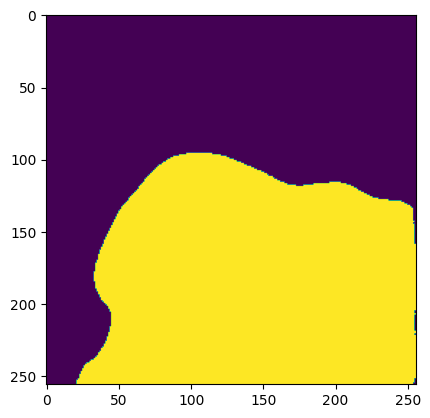

In [ ]:
plt.imshow(pred[0][0].detach().cpu().numpy() > 0)

Видно, что результат решения задачи сегментации изображение сегментировано не очень хорошо.

## Обучение на всей тренировочной выборке

In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(x_test, batch_size=batch_size)

In [ ]:
from torch.utils.data.datapipes.datapipe import UNTRACABLE_DATAFRAME_PIPES

model = UNet(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())

stats_all = train(model, optimizer, train_loader, test_loader, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
df_all = pd.DataFrame(stats_all,columns=title)
df_all.to_csv("stats.csv")

## Кривые Loss и Jaccard Index для модели, обученной на всей тренировочной выборке

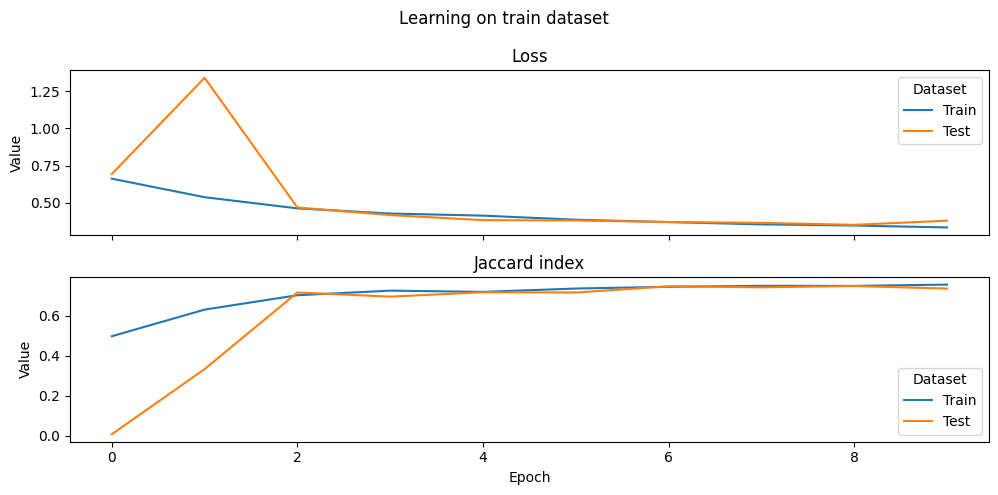

In [ ]:
show_loss_and_jaccard_index(pd.read_csv("stats.csv"), "Learning on train dataset")

## top N самых плохих предсказаний

In [ ]:
def show_image_and_mask(image, mask):
    _, (ax_l, ax_r) = plt.subplots(ncols=2)
    ax_l.imshow(image.permute(1, 2, 0))
    ax_r.imshow(mask[0].detach().cpu().numpy())

In [ ]:
def show_worst_predictions(net, number):
    predictions = []
    for i, data in tqdm(enumerate(test_loader, 0)):
        x = data[0]
        y = data[1]
        pred = net(x.cuda())
        metric = calculate_jaccard_index(pred, y).item()
        predictions.append((metric, i))

    worst_predictions = sorted(predictions)[:number]
    for _, idx in worst_predictions:
        image, mask = x_test[idx]
        pred = net(image.cuda().unsqueeze(0))
        show_image_and_mask(image, pred[0])

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


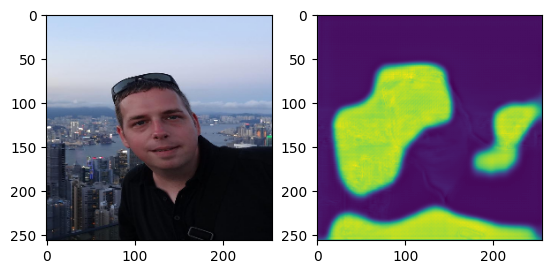

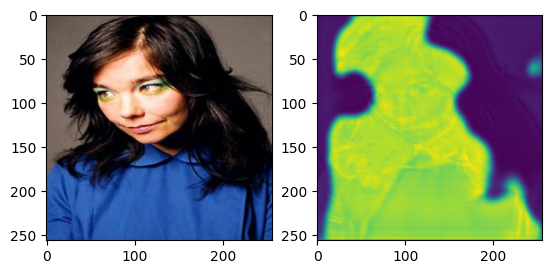

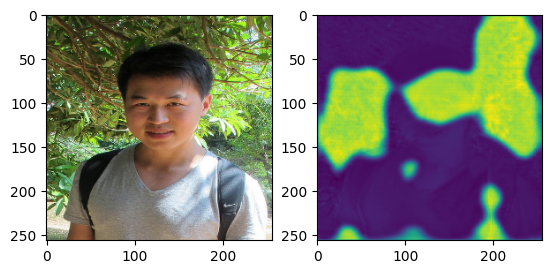

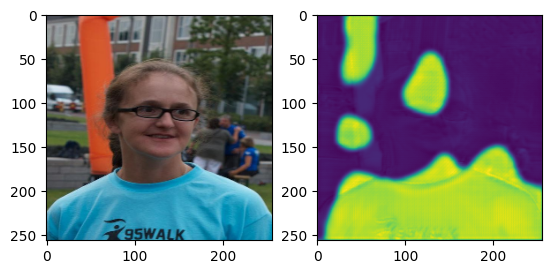

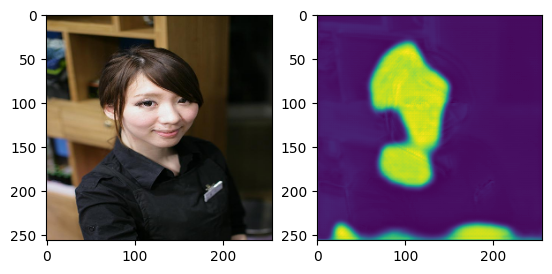

In [ ]:
show_worst_predictions(net, 5)

Можно видеть, что низкое качество решения задачи сегментации для данных пяти изображений обусловлено тем, что каждое из этих изображений -- сложжное. На первом, третьем, четвертом и пятом изображениях присутствует яркий контрастный фон, который осложняет распознавание человека. На втором изображении волосы на правой части головы девушки очень темные и могут быть восприняты как темный фон. При этом левая часть головы девушки сегментируется корректно.

## Улучшение качества без изменения архитектуры: гиперпараметры

In [ ]:
def train_and_save_to_csv(padding, train_loader, test_loader):
    net = UNet(3, padding, 1).cuda()
    optimizer = torch.optim.Adam(net.parameters())

    stats = train(net, optimizer, train_loader, test_loader, 10)
    df = pd.DataFrame(stats,columns=title)
    df.to_csv(f"stats-padding-{padding}.csv")

padding_parameters = [8, 16, 32]
for padding in padding_parameters:
    print("Training UNet with", padding, "padding")
    train_and_save_to_csv(padding, train_loader, test_loader)

Training UNet with 8 padding


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training UNet with 16 padding


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training UNet with 32 padding


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

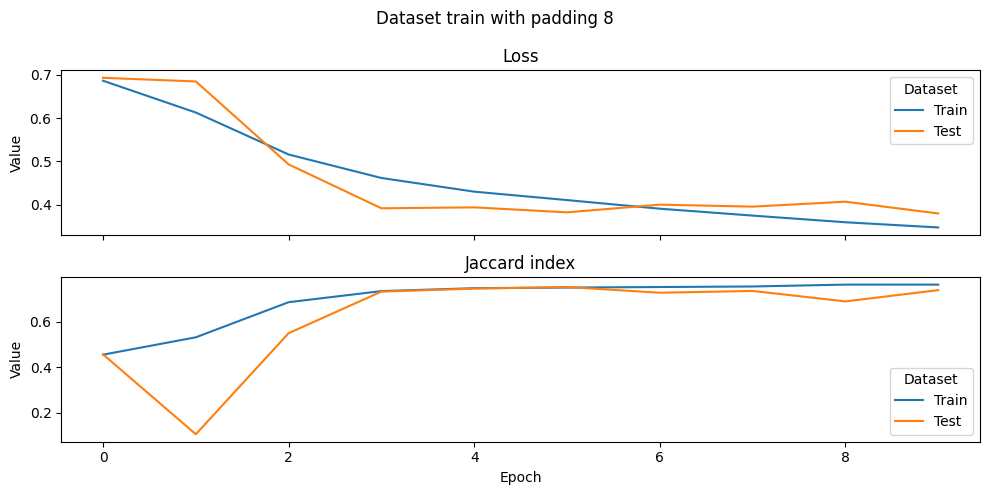

In [ ]:
results = pd.read_csv("stats-padding-8.csv")
show_loss_and_jaccard_index(results, "Dataset train with padding 8")

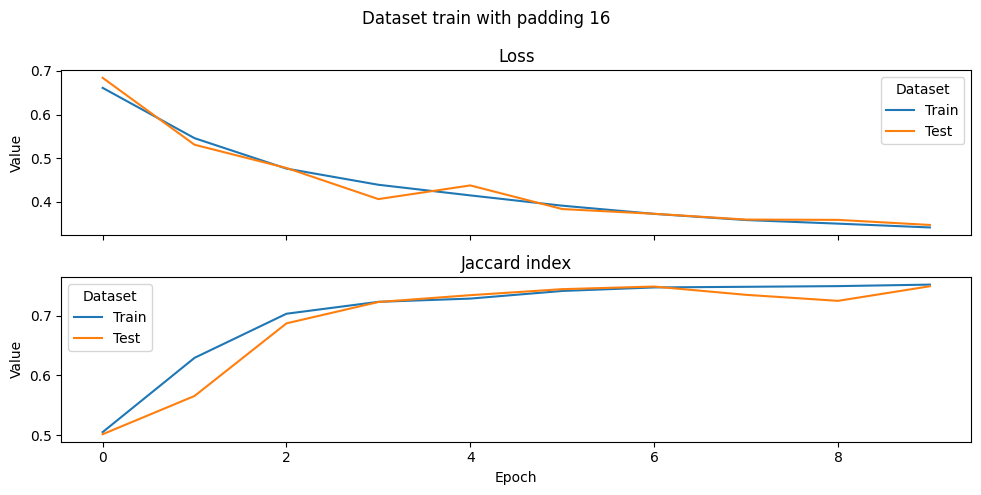

In [ ]:
results = pd.read_csv("stats-padding-16.csv")
show_loss_and_jaccard_index(results, "Dataset train with padding 16")

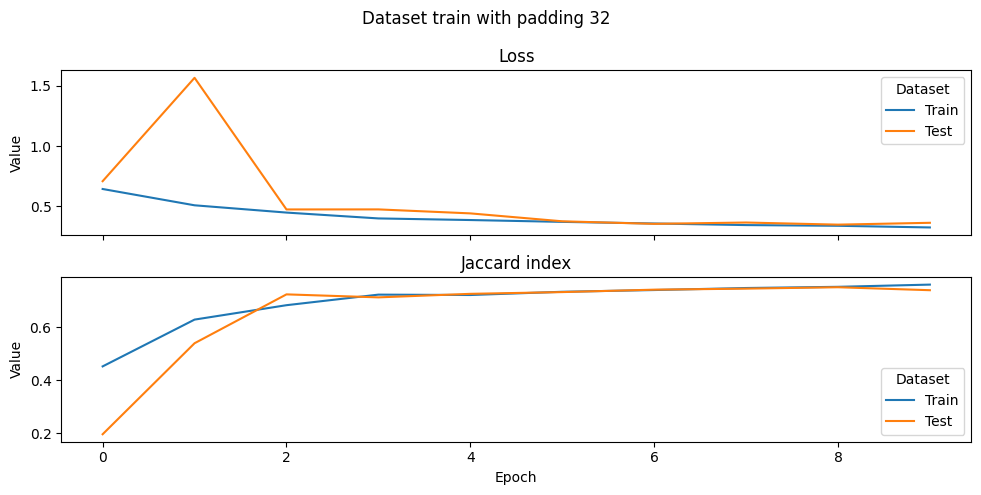

In [ ]:
results = pd.read_csv("stats-padding-32.csv")
show_loss_and_jaccard_index(results, "Dataset train with padding 32")

Из графиков следует, что с увеличением padding параметра Loss быстрее стремится к нулю, а Jaccard Index быстрее возрастает при начальных эпохах. При этом максимальное значение Jaccard Index достигается при padding = 8: оно достигает больше 0.7

## Улучшение качества без изменения архитектуры: аугментация

In [ ]:
class SegmentationTTAWrapper(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net


    def horizontal_flip(self, image):
        # Use p = 1 to flip image.
        transformation = T.RandomHorizontalFlip(p=1)
        return transformation(image)
    

    def forward(self, image):
        flipped_image = self.horizontal_flip(image)
        concatenated_image = torch.cat([image, flipped_image])
        prediction = self.net(concatenated_image)

        result, augmented_result = prediction.chunk(2)
        flipped_augmented_result = self.horizontal_flip(augmented_result)

        return torch.mean(torch.stack([result, flipped_augmented_result]), dim=0)

In [ ]:
net = UNet(3, 8, 1).cuda()
tta_net = SegmentationTTAWrapper(net).cuda()

optimizer = torch.optim.Adam(tta_net.parameters())
stats = train(tta_net, optimizer, train_loader, test_loader, 10)
df = pd.DataFrame(stats,columns=title).to_csv(f"results-tta.csv")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

Training batch:   0%|          | 0/13 [00:00<?, ?it/s]

Test batch:   0%|          | 0/113 [00:00<?, ?it/s]

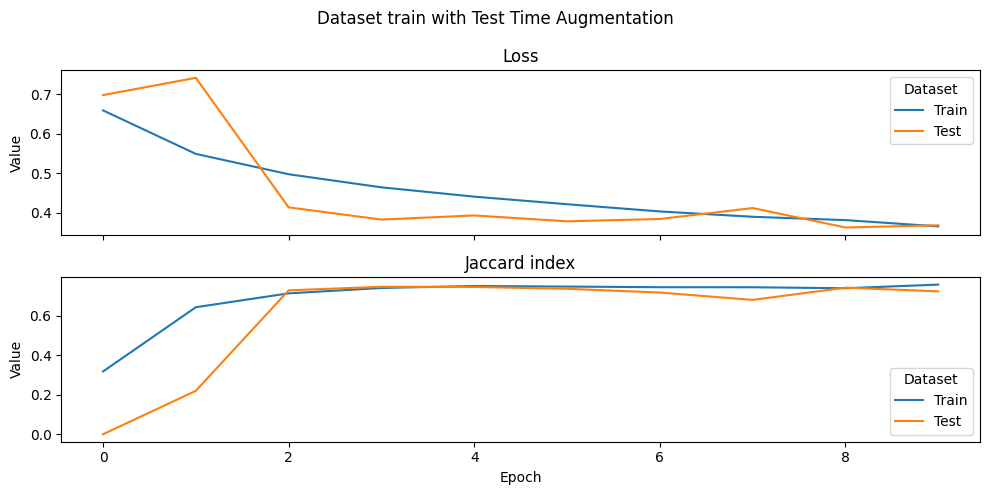

In [ ]:
results = pd.read_csv("results-tta.csv")
show_loss_and_jaccard_index(results, "Dataset train with Test Time Augmentation")

## Улучшение качества путем изменения архитектуры:

Попробуем рассмотреть UNet с другой архитектурой и проверить, получится ли с помощью не получить лучшие результаты.

In [94]:
import torch.nn.functional as F

class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet2, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [95]:
net = UNet2(n_channels=3, n_classes=1).cuda()
net = net.cuda()

In [96]:
stats = train(net, optimizer, train_loader, test_loader, 30)
df = pd.DataFrame(stats, columns=title)
df.to_csv("stats-new-arch.csv")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Training batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

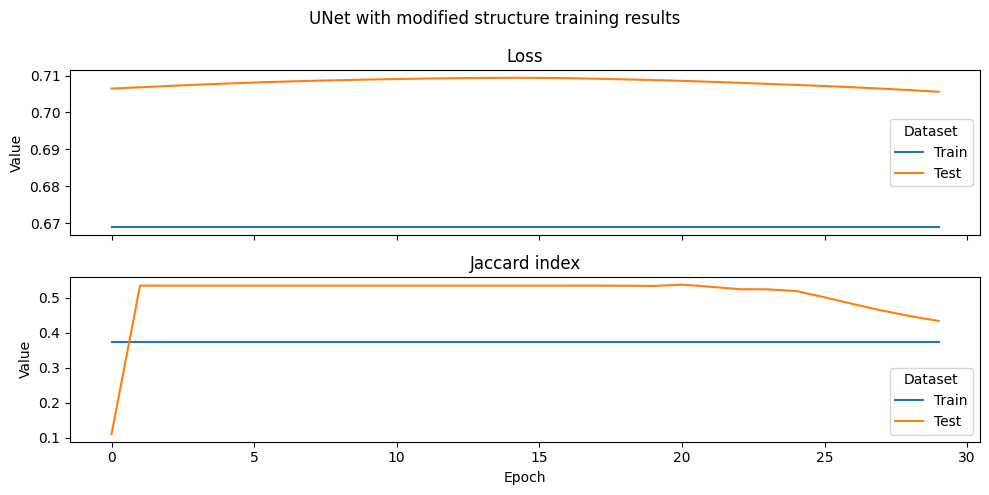

In [97]:
results = pd.read_csv("stats-new-arch.csv")
show_loss_and_jaccard_index(results, "UNet with modified structure training results")

## Анализ получившихся результатов
- Переобучение на одном батче ожидаемо позволило получить очень хорошие результаты решения задачи сегментации на тренировочной выборке и достаточно плохие на тестовой выборке
- Обучение на всей тренировочной выборке позволило достичь Jaccard Index на тестовой и тренировочной выборках, превышающий 0.6
- Худшие решения задачи сегментации на тестовой выборке были для изображений людей с контрастным фоном, на котором сложно выявить лицо и силуэт человека
- Наилучшие результаты в решении задачи сегментации удалось получить при подборе гиперпараметра padding, Jaccard Index превышает 0.7 при значении padding 8
